In [1]:
import re
import os
import sys
from lca_algebraic import initProject
import pandas as pd
import numpy as np
import xarray as xr
import lca_algebraic as agb
from lca_algebraic import *
from lca_algebraic.stats import * 
import bw2data, bw2io
import bw2calc
from premise import *
import premise as prm
from itertools import zip_longest
from premise_gwp import add_premise_gwp
from scipy.integrate import cumtrapz

In [2]:
sys.path.append('/Users/susierwu/Dropbox/DLCA_DynCO2/pdpLCA_GT/') 
from utils import *
#from utils.setup import *
from utils.setup_whdLCIA import *
from utils.getAct import *
from utils.utils import *
from utils.dlcia_functions import *

For dpLCIA, match dpCFs for each SSP[x], Year[t] by calling functions from dlcia_functions.py  
Mapping premise_remind_DB to SSPx defined here:  {'SSP1-PkBudg500': 'ssp119', 'SSP2-Base': 'ssp245', 'SSP5-Base': 'ssp585'}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [3]:
bw2data.projects.set_current('iveo_v1')
mybio = bw2data.Database("biosphere3")
initProject("iveo_v1")

Biosphere database already present!!! No setup is needed


In [4]:
print( ssp_scn  , ssp_yr) 
bw2_method_metric = 'dpIRF'
#ds_rename = 'dpIRF'

root_path = '/Users/susierwu/Dropbox/DLCA_DynCO2/pdpLCA_GT/'
p_file = os.path.abspath(os.path.join(root_path, 'data/P_files/p_tech_perSSP_Y.xlsx'))

['_remind_SSP1-PkBudg500', '_remind_SSP2-Base', '_remind_SSP5-Base'] [2030, 2040, 2050]


### init 

In [5]:
pdb = bw.Database("iveo_Parameterized_v1")
print(len(pdb))

384


In [6]:
#resetParams()
agb.loadParams()
#agb.list_parameters()

[ParamRegistry] Param NMC622_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param NCA_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LFP_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LTO_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LSB_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LSB_cell_assmb_NG_MJperkg was already defined in '<project>' : overriding.
[ParamRegistry] Param LSB_cell_assmb_elec_kWhperkg was already defined in '<project>' : overriding.
[ParamRegistry] Param g_truck_vehicle_prod_lightweighting was already defined in '<project>' : overriding.
[ParamRegistry] Param battery_total_capacity_for_gtruck was already defined in '<project>' : overriding.
[ParamRegistry] Param biodiesel_UCO_perc was already defined in '<project>' : overriding.
[ParamRegistry] Pa

### get already created UPR: 

In [8]:
icevgtruck_finalallsspyear = [] 
for prm_name in ssp_scn:
    for year_t in ssp_yr: 
        bg_db_ssp_yr = bg_ei_ + prm_name + "_" + str(year_t)            # backgroun database (BD) to use for SSP[x], Year[t]
        copied_prm_UPR_suffix = "_from_" + prm_name + "_" + str(year_t) # copy UPR from BD to PDB for further use/modification if needed
        newUPR_suffix =  "_wh_" + prm_name + "_" + str(year_t)          # naming on any new UPRs created in PDB
        # final one unit of g_truck with lightweighting as Parameter: 
        gtruck_final  = agb.findActivity(
                db_name = PDB_NAME,
                name="V1A_g-truck ICEV-d Vehicle Production_" + newUPR_suffix)
        icevgtruck_finalallsspyear.append(gtruck_final)

len(icevgtruck_finalallsspyear)

9

#### B.0 test opening Parameter file

In [8]:
root_path = '/Users/susierwu/Dropbox/DLCA_DynCO2/pdpLCA_GT/'
p_file = os.path.abspath(os.path.join(root_path, 'data/P_files/p_tech_perSSP_Y.xlsx'))

for gtruck_final in icevgtruck_finalallsspyear:
    # need a matched YearlyParams for each SSPx:
    str1 = gtruck_final.as_dict()["name"]
    str2 = str1.split("remind_")[1]
    year_to_get_inP = int( str2.split("_")[-1] )
    ssp_remind = str2.split("_")[0] 
    ssp_to_get_inP = ssp_remind_Pname_map.get(ssp_remind)
    
    yearlyParams = loadYearlyParams_multisheet(PARAMS_FILE = p_file, s_name = ['V1A_g_truck'], years = [year_to_get_inP], SSP = ssp_to_get_inP) 
    print(f"for SSP {ssp_to_get_inP}, year {year_to_get_inP}, P:  {yearlyParams}" )

for SSP ssp119, year 2030, P:  {'g_truck_vehicle_prod_lightweighting': [260.0], 'battery_total_capacity_for_gtruck': [376.0]}
for SSP ssp119, year 2040, P:  {'g_truck_vehicle_prod_lightweighting': [314.6], 'battery_total_capacity_for_gtruck': [346.5216]}
for SSP ssp119, year 2050, P:  {'g_truck_vehicle_prod_lightweighting': [380.6660000000001], 'battery_total_capacity_for_gtruck': [319.35430656]}
for SSP ssp245, year 2030, P:  {'g_truck_vehicle_prod_lightweighting': [237.0], 'battery_total_capacity_for_gtruck': [376.0]}
for SSP ssp245, year 2040, P:  {'g_truck_vehicle_prod_lightweighting': [261.2925], 'battery_total_capacity_for_gtruck': [361.1104]}
for SSP ssp245, year 2050, P:  {'g_truck_vehicle_prod_lightweighting': [288.07498125000006], 'battery_total_capacity_for_gtruck': [346.81042816]}
for SSP ssp585, year 2030, P:  {'g_truck_vehicle_prod_lightweighting': [237.0], 'battery_total_capacity_for_gtruck': [376.0]}
for SSP ssp585, year 2040, P:  {'g_truck_vehicle_prod_lightweighting':

## C. running dpIRF :: no tech_switch parameter for ICEV-d truck production


#### C.B.2 V1A_module manfu impacts, adding run_y loop, even if it only has initial impacts, to make the same results shape as other modules

In [9]:
v_lifetime = 20  
GWP_list, SSP_list, Year_list, tech_list, run_Y_list  = [], [],[], [], []

""" first loop is for each v_year:: [year_to_get_inP] and  SSP:: [ssp_to_get_inP]""" 
for gtruck_final_ in icevgtruck_finalallsspyear:
    #print(gtruck_final_)
    # need a matched YearlyParams for each SSPx:
    str1 = gtruck_final_.as_dict()["name"]
    str2 = str1.split("remind_")[1]
    year_to_get_inP = int( str2.split("_")[-1] )
    ssp_remind = str2.split("_")[0] 
    ssp_to_get_inP = ssp_remind_Pname_map.get(ssp_remind)

    """ for each LCI scenario, using a respective SSP[x] as the dLCIA method """ 
    chosen_methods_perssp = get_my_dpLCIA(ssp = ssp_to_get_inP, my = year_to_get_inP, metric = bw2_method_metric )

    """ for ICEV-d, only read from one sheet  V1A_g_truck with  one Parameter lightweight """ 
    yearlyParams = loadYearlyParams_multisheet(PARAMS_FILE = p_file, s_name = ['V1A_g_truck' ], years = [year_to_get_inP], SSP = ssp_to_get_inP) 
    #print(f"for SSP {ssp_to_get_inP}, year {year_to_get_inP}, P:  {yearlyParams}" )

    """ for ICEV-d, add a dummy tech under SSPx, Year[t], since it doens't have switch_tech  """
    """ still keep a dummy_tech, so that final results ds shape is same as BEV """ 
    for tech in ['dummy_tech'] :
        
        run_Y_GWP_list,run_Y_SSP_list, run_Y_Year_list, run_Y_tech_list, run_Y = [],[],[],[],[] 
        """ for initial V_manuf impacts, only run one year impact  """ 
        for Y in range(year_to_get_inP, year_to_get_inP + 1 ):      
            df= agb.multiLCAAlgebric(models=[
                (gtruck_final_, 1)],  #act_test
                methods = chosen_methods_perssp,   
                #define switch parameter here if you have one, 
                #gtruck_BEV_battery_tech = b_tech ,
                **yearlyParams
            )

            print(f"end of running LCA calc for SSP {ssp_to_get_inP} and year {year_to_get_inP} using tech {tech} for {gtruck_final_} ")
            #display(df)
            
            """ to have all 100 years run for dynamic LCIA """ 
            lcia_allyears = [] 
            for t in range(len(df.columns)): 
                lcia_t = df.iloc[:,t].values[0]
                lcia_allyears.append(lcia_t)
            
            run_Y_GWP_list.append(lcia_allyears)
            run_Y_SSP_list.append(ssp_to_get_inP) 
            run_Y_Year_list.append(year_to_get_inP)
            run_Y_tech_list.append(tech)
            run_Y.append(Y)
            print(len(run_Y_GWP_list),len(run_Y_SSP_list),len(run_Y_Year_list),len(run_Y_tech_list),len(run_Y))
        
        GWP_list.append(run_Y_GWP_list)
        SSP_list.append(run_Y_SSP_list) 
        Year_list.append(run_Y_Year_list)
        tech_list.append(run_Y_tech_list)        
        run_Y_list.append(run_Y) 

dpLCIA methods for SSP 119, MY2030 is, for example for year 41,: ('IPCC 2021 - dpCFsSSP119_MY2030 - year41', 'climate change', 'dpIRF41'), total len: 101  
end of running LCA calc for SSP ssp119 and year 2030 using tech dummy_tech for 'V1A_g-truck ICEV-d Vehicle Production__wh__remind_SSP1-PkBudg500_2030' (one_truck, GLO, None) 
1 1 1 1 1
dpLCIA methods for SSP 119, MY2040 is, for example for year 60,: ('IPCC 2021 - dpCFsSSP119_MY2040 - year60', 'climate change', 'dpIRF60'), total len: 101  
end of running LCA calc for SSP ssp119 and year 2040 using tech dummy_tech for 'V1A_g-truck ICEV-d Vehicle Production__wh__remind_SSP1-PkBudg500_2040' (one_truck, GLO, None) 
1 1 1 1 1
dpLCIA methods for SSP 119, MY2050 is, for example for year 46,: ('IPCC 2021 - dpCFsSSP119_MY2050 - year46', 'climate change', 'dpIRF46'), total len: 101  
end of running LCA calc for SSP ssp119 and year 2050 using tech dummy_tech for 'V1A_g-truck ICEV-d Vehicle Production__wh__remind_SSP1-PkBudg500_2050' (one_truck,

### C. final ds prep  

In [10]:
d1 = get_dlcia_rawtable_a(SSP_list,run_Y_list,tech_list, Year_list, GWP_list)
dlcia_ds = get_dlcia_ds_b(d1) 
d1

0             1             2    \
SSP    v_year tech_list  run_year                                             
ssp119 2030   dummy_tech 2030      2.502864e-10  2.325472e-10  2.174271e-10   
       2040   dummy_tech 2040      2.211680e-10  2.055065e-10  1.921392e-10   
       2050   dummy_tech 2050      2.130380e-10  1.978030e-10  1.847368e-10   
ssp245 2030   dummy_tech 2030      2.838960e-10  2.637268e-10  2.465360e-10   
       2040   dummy_tech 2040      2.467191e-10  2.293927e-10  2.146626e-10   
       2050   dummy_tech 2050      2.216778e-10  2.061443e-10  1.928391e-10   
ssp585 2030   dummy_tech 2030      2.915065e-10  2.701823e-10  2.520367e-10   
       2040   dummy_tech 2040      2.617659e-10  2.423455e-10  2.258300e-10   
       2050   dummy_tech 2050      1.934148e-10  1.793104e-10  1.672892e-10   

                                            3             4             5    \
SSP    v_year tech_list  run_year                                             
ssp119 2030   dummy_tech 2030      2.044372e-10  1.931891e-10  1.833778e-10   
       2040   dummy_tech 2040      1.806253e-10  1.706104e-10  1.618460e-10   
       2050   dummy_tech 2050      1.734721e-10  1.636981e-10  1.551236e-10   
ssp245 2030   dummy_tech 2030      2.318176e-10  2.191069e-10  2.079787e-10   
       2040   dummy_tech 2040      2.019850e-10  1.909940e-10  1.813807e-10   
       2050   dummy_tech 2050      1.813720e-10  1.714461e-10  1.627219e-10   
ssp585 2030   dummy_tech 2030      2.365119e-10  2.231307e-10  2.114677e-10   
       2040   dummy_tech 2040      2.117120e-10  1.994821e-10  1.888263e-10   
       2050   dummy_tech 2050      1.569752e-10  1.480296e-10  1.402885e-10   

                                            6             7             8    \
SSP    v_year tech_list  run_year                                             
ssp119 2030   dummy_tech 2030      1.747415e-10  1.671131e-10  1.602894e-10   
       2040   dummy_tech 2040      1.541580e-10  1.473268e-10  1.412360e-10   
       2050   dummy_tech 2050      1.475611e-10  1.408460e-10  1.348457e-10   
ssp245 2030   dummy_tech 2030      1.982244e-10  1.896150e-10  1.819439e-10   
       2040   dummy_tech 2040      1.729446e-10  1.654600e-10  1.588093e-10   
       2050   dummy_tech 2050      1.550716e-10  1.482810e-10  1.422164e-10   
ssp585 2030   dummy_tech 2030      2.012212e-10  1.922348e-10  1.842439e-10   
       2040   dummy_tech 2040      1.795407e-10  1.713625e-10  1.641109e-10   
       2050   dummy_tech 2050      1.334761e-10  1.274553e-10  1.221240e-10   

                                            9    ...           91   \
SSP    v_year tech_list  run_year                ...                 
ssp119 2030   dummy_tech 2030      1.542064e-10  ...  6.847178e-11   
       2040   dummy_tech 2040      1.357698e-10  ...  5.877146e-11   
       2050   dummy_tech 2050      1.294634e-10  ...  5.522487e-11   
ssp245 2030   dummy_tech 2030      1.750910e-10  ...  7.880979e-11   
       2040   dummy_tech 2040      1.528221e-10  ...  6.737841e-11   
       2050   dummy_tech 2050      1.367818e-10  ...  5.932345e-11   
ssp585 2030   dummy_tech 2030      1.771368e-10  ...  8.093312e-11   
       2040   dummy_tech 2040      1.576517e-10  ...  7.180308e-11   
       2050   dummy_tech 2050      1.173977e-10  ...  5.308106e-11   

                                            92            93            94   \
SSP    v_year tech_list  run_year                                             
ssp119 2030   dummy_tech 2030      6.828559e-11  6.810257e-11  6.792281e-11   
       2040   dummy_tech 2040      5.861045e-11  5.845240e-11  5.829725e-11   
       2050   dummy_tech 2050      5.507367e-11  5.492524e-11  5.477949e-11   
ssp245 2030   dummy_tech 2030      7.859620e-11  7.838647e-11  7.818051e-11   
       2040   dummy_tech 2040      6.719467e-11  6.701426e-11  6.683714e-11   
       2050   dummy_tech 2050      5.916118e-11  5.900181e-11  5.884524e-11   
ssp585 2030   dummy_tech 2030  

In [11]:
dlcia_ds

<xarray.Dataset>
Dimensions:    (SSP: 3, v_year: 3, tech_list: 1, run_year: 3, lcia_year: 101)
Coordinates:
  * SSP        (SSP) object 'ssp119' 'ssp245' 'ssp585'
  * v_year     (v_year) int64 2030 2040 2050
  * tech_list  (tech_list) object 'dummy_tech'
  * run_year   (run_year) int64 2030 2040 2050
  * lcia_year  (lcia_year) int64 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
Data variables:
    value      (SSP, v_year, tech_list, run_year, lcia_year) float64 2.503e-1...

#### C.3.2. assign the data var dlcia to the ds for each / SSP / Year / lcia_year

In [12]:
ds = get_dlcia_final_ds_empty_c(dlcia_ds, v_module_touse = ['V1A_V1B_init']) 
#ds

 enter one of the following for v_module to arrange dpLCIA results:  ['V1A_V1B_init'] for init_veh both ICEV&BEV,           ['V1B']/ for BEV bat replacement, ['V2_oper'] for ICEV on-road emissions,  ['F2_fuel_diesel'] or ['F2_fuel_elec'] for fuel 
empty final ds prepared with fake data


In [13]:
mod_toget = "V1A_V1B_init" 
for sp in dlcia_ds['SSP'].values:
    for v_y  in dlcia_ds['v_year'].values:
        for tech in dlcia_ds['tech_list'].values:
            
            """ for each running year, need to prepare dplcia scores """ 
            run_y_list = []
            for r_y in dlcia_ds['run_year'].values:
                sel_ds = dlcia_ds.sel(SSP = sp, v_year = v_y, tech_list = tech, run_year = r_y) 
                sel_ds1 = sel_ds.where(sel_ds['value'].notnull() , drop = True)
                if len(sel_ds1['value'].values) != 0 : 
                    run_y_list.append(sel_ds1['value'].values)
                else:
                    pass
            
            """ 1. add N * [0] for each future run_year so that it can be summed later """
            final_run_y_list, run_y_list_padded = [] , []
            for i in range(len(run_y_list)):  
                # Create a numpy array with i zeros, depending on future year position 
                shape = (i, )
                zeros = np.zeros(shape) 
                run_y_list_padded = np.concatenate((zeros, run_y_list[i]))
                """ 2. append each year to the final list, to sum later """ 
                final_run_y_list.append(run_y_list_padded)
            
            """ 3. sum over all running years' lcia score for TH:Year[0] + Year[100+lci_year] """ 
            allrun_y_lcia = [sum(filter(None, x)) for x in zip_longest(*final_run_y_list, fillvalue=0)]
            irf_score = np.array(allrun_y_lcia)
            crf_score_bad =  np.cumsum(irf_score)
            
            # using cumtrapz for time-integral, more accurate to calculate CRF, slightly different from cumsum above 
            xt = np.arange(irf_score.shape[0])              
            crf_score = cumtrapz(irf_score, xt, initial=0)
            #print(crf_score_bad, "\n", crf_score)

            # wanna three data variables instead of 'dpLCA_IC' dimension, but for now it's a workout
            to_addvar_ds_shape = ds['dplcia'].loc[{'SSP': sp, 'v_year': v_y, 'v_module': mod_toget, 'dpLCA_IC': 'dpIRF' , 'tech_list':tech, 'ensemble':0}].shape
            if to_addvar_ds_shape == irf_score.shape == crf_score.shape: 
                # WHY ds can't assign data variable with diff. values, I wanna have three seperate variable (w/o)dpLCA_IC dim,   
                #ds['dpIRF'].loc[{'SSP': sp, 'v_year': v_y, 'v_module':mod_toget, 'tech_list':tech, 'ensemble':0 }]  = irf_score
                #ds['dpCRF'].loc[{'SSP': sp, 'v_year': v_y, 'v_module':mod_toget, 'tech_list':tech, 'ensemble':0 }]  = crf_score
                for impact in  ['dpIRF', 'dpCRF', 'dpGWP']: 
                    if impact == "dpIRF": 
                        ds['dplcia'].loc[{'SSP': sp, 'v_year': v_y, 'v_module':mod_toget, 'tech_list':tech, 'dpLCA_IC':impact, 'ensemble':0 }]  = irf_score
                    elif impact == 'dpCRF': 
                        ds['dplcia'].loc[{'SSP': sp, 'v_year': v_y, 'v_module':mod_toget, 'tech_list':tech, 'dpLCA_IC':impact, 'ensemble':0 }]  = crf_score
                    else: 
                        print("no dpLCA score for dpGWP yet ")
            else:
                print("no LCIA score added")
            

no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 


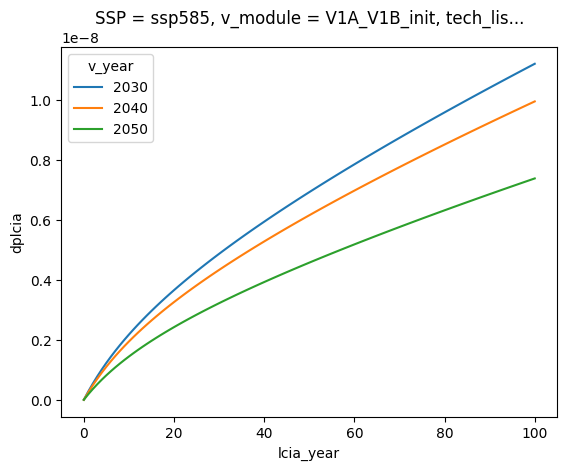

In [14]:
ds.sel( tech_list = 'dummy_tech', v_module = 'V1A_V1B_init', SSP = 'ssp585', dpLCA_IC = 'dpCRF', ensemble = 0 )["dplcia"].plot(x='lcia_year', hue= 'v_year' );

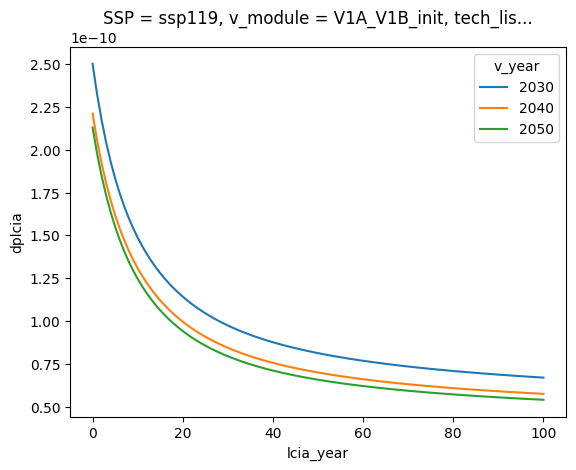

In [15]:
ds.sel( tech_list = 'dummy_tech', v_module = 'V1A_V1B_init', SSP = 'ssp119', dpLCA_IC = 'dpIRF',  ensemble = 0 )["dplcia"].plot(x='lcia_year', hue= 'v_year' );

In [16]:
ds.to_netcdf('../dlcia_output/V1A_ICEVdGT_dpIRFCRF.nc')

In [17]:
ds

<xarray.Dataset>
Dimensions:    (SSP: 3, v_year: 3, v_module: 1, tech_list: 1, lcia_year: 101,
                dpLCA_IC: 3, ensemble: 1001)
Coordinates:
  * SSP        (SSP) object 'ssp119' 'ssp245' 'ssp585'
  * v_year     (v_year) int64 2030 2040 2050
  * v_module   (v_module) <U12 'V1A_V1B_init'
  * tech_list  (tech_list) object 'dummy_tech'
  * lcia_year  (lcia_year) int64 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
  * dpLCA_IC   (dpLCA_IC) <U5 'dpIRF' 'dpCRF' 'dpGWP'
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Data variables:
    dplcia     (SSP, v_year, v_module, tech_list, lcia_year, dpLCA_IC, ensemble) float64 ...